### **Carregando as bibliotecas e importando os dados**

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, recall_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from scipy.stats import uniform, loguniform
from IPython.display import Markdown
from scipy.stats import randint
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x) #Não deixa em notação ciêntifica

In [2]:
# Carregando o arquivo em JON onde está as chaves de acesso para conectar no banco de dados.
with open('config/config.json', 'r') as config_file:
    config = json.load(config_file)

In [3]:
# Capturando os dados
DB_USER = config['db_user']
DB_PASSWORD = config['db_password']
DB_NAME = config['db_name']
DB_HOST = config['db_host']

In [4]:
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}')

In [5]:
# Executando a consulta para captura dos dados e transformando eles em um dataset.
data = """
SELECT 
        CUSTOMER.CUSTOMER_ID,
        INVENTORY.FILM_ID,
        PAYMENT.AMOUNT,
        RENTAL.RENTAL_DATE,
        INVENTORY.STORE_ID,
        RENTAL.STAFF_ID,
        FILM.RENTAL_DURATION,
        CUSTOMER.ACTIVE AS CHURN
FROM CUSTOMER
JOIN PAYMENT ON PAYMENT.CUSTOMER_ID = CUSTOMER.CUSTOMER_ID
JOIN RENTAL ON RENTAL.CUSTOMER_ID = CUSTOMER.CUSTOMER_ID
JOIN INVENTORY ON INVENTORY.INVENTORY_ID = RENTAL.INVENTORY_ID
JOIN FILM ON FILM.FILM_ID = INVENTORY.FILM_ID
"""

data = pd.read_sql_query(data, engine)

### **Funções Auxiliares**

In [6]:
def df_informations(df):
    # Informações básicas
    num_rows, num_cols = df.shape
    text = f'O dataset tem {num_rows} linhas e {num_cols} colunas.'

    # Informações sobre valores nulos
    df_info = pd.DataFrame({
        'Nao Nulos': df.notnull().count(),
        'Nulos': df.isnull().sum(),
        'Percentual de Nulos': df.isnull().mean(),
        'Unicos': df.nunique(),
        'Tipos': df.dtypes
    })

    # Informações sobre os tipos de dados
    df_dtype = df_info['Tipos'].value_counts().reset_index()
    df_dtype.columns = ['Tipos', 'Count']
    df_dtype['Porcentagem'] = (df_dtype['Count'] / num_cols).round(2)

    # Estilizando os DataFrames
    df_info = df_info.style.background_gradient(cmap='jet', subset=['Percentual de Nulos']).format({'Percentual de Nulos': '{:.2%}'})
    df_dtype = df_dtype.style.background_gradient(cmap='YlGn', subset=['Porcentagem']).format({'Porcentagem': '{:.2%}'})

    # Exibir as informações
    display(Markdown("<H3 style='text-align:left;float:left;'>Informações Sobre o dataset"))
    display(Markdown(f'<H5> {text}'))
    display(df_info)
    display(Markdown("<H3 style='text-align:left;float:left;'>Sobre o dtypes nós temos:"))
    display(df_dtype)

#### **Conhecendo os dados**

In [7]:
df_informations(data)

<H3 style='text-align:left;float:left;'>Informações Sobre o dataset

<H5> O dataset tem 445483 linhas e 8 colunas.

,Nao Nulos,Nulos,Percentual de Nulos,Unicos,Tipos
customer_id,445483,0,0.00%,599,int64
film_id,445483,0,0.00%,958,int64
amount,445483,0,0.00%,19,float64
rental_date,445483,0,0.00%,15815,"datetime64[ns, UTC]"
store_id,445483,0,0.00%,2,int64
staff_id,445483,0,0.00%,2,int64
rental_duration,445483,0,0.00%,5,int64
churn,445483,0,0.00%,2,int64


<H3 style='text-align:left;float:left;'>Sobre o dtypes nós temos:

,Tipos,Count,Porcentagem
0,int64,6,75.00%
1,float64,1,12.00%
2,"datetime64[ns, UTC]",1,12.00%


In [8]:
data.describe(percentiles=[0.01, 0.1, 0.25, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
customer_id,445483.00,294.02,171.70,1.00,6.00,56.00,146.00,292.00,442.00,533.00,593.00,599.00
film_id,445483.00,501.17,288.30,1.00,10.00,101.00,255.00,498.00,752.00,897.00,990.00,1000.00
amount,445483.00,4.20,2.37,0.00,0.99,0.99,2.99,3.99,4.99,6.99,9.99,11.99
store_id,445483.00,1.51,0.50,1.00,1.00,1.00,1.00,2.00,2.00,2.00,2.00,2.00
staff_id,445483.00,1.50,0.50,1.00,1.00,1.00,1.00,1.00,2.00,2.00,2.00,2.00
rental_duration,445483.00,4.94,1.40,3.00,3.00,3.00,4.00,5.00,6.00,7.00,7.00,7.00
churn,445483.00,0.97,0.16,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [9]:
"""Alterando os valores da colunas churn, como ela anteriormente estava como "active", iremos alterar os clientes ativos para "No"
e os clientes inativos para Yes."""

data['churn'] = data['churn'].replace({0: 'Sim', 1: 'Não'})

**Sobre o dataset**
1. Todas as nossas colunas já estão no formato corret então não será necessário fazer nenhuma alteração sobre isso.
2. Observando o nosso describe não notamos nenhum valor discrepante ou erros aparentes, iremos observar isso mais afundo na análise gráfica.
3. A coluna de costumer_id não será utilizada para modelagem pois ela iria causa data leakage no modelo então iremos remover mais para frente.

### **Análise Gráfica**

* Como primeiro gráfico utilizaremos o boxplot, ele será utilizado com o objetivo de notar possíveis anomalias nos dados, principalmente no rental_duration e amount.

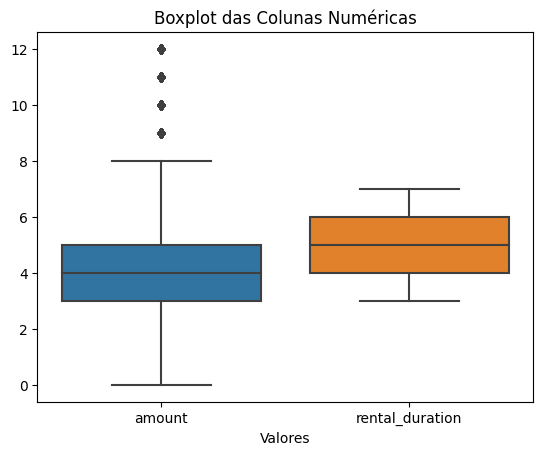

In [10]:
col_num = ['amount', 'rental_duration']
sns.boxplot(data=data[col_num], orient="v")
plt.xlabel("Valores")
plt.title("Boxplot das Colunas Numéricas")
plt.show()

* Dentro do boxplot apesar de ter alguns valores fora dos quartis em amount não aparenta ser nenhum erro então não iremos remover. 

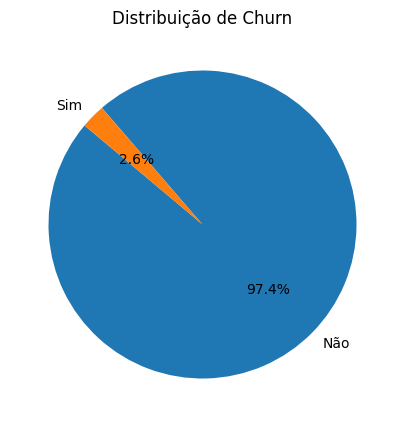

In [11]:
churn_counts = data['churn'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição de Churn')
plt.show()

* Como esperado para um caso de churn temos uma classe bem desequilibrada, sendo somente 2.6% dos dados sendo considerados churn.

### **Data Preparation**

* Dentro do data preparation não teremos muitos ajustes para fazer aos dados, uma vez que todos os dados já estão no formato correto e não será necessário fazer nenhum encoder ou algo do tipo, o único ajuste que será necessário é retirar a coluna "customer_id", essa coluna é o id_único do usuário e como temos mais de uma transação por usuário manter essa coluna iria causar um data leakage. 

**O que é o data leakage?**

* Data leakage em machine learning ocorre quando informações indevidas, não disponíveis no momento da previsão real, são inadvertidamente incorporadas ao treinamento do modelo, resultando em previsões imprecisas. 

In [12]:
data.drop('customer_id', axis=1, inplace=True)


In [13]:
data['rental_date'] = data['rental_date'].apply(lambda x: x.timestamp())
data['churn'] = data['churn'].replace({"Não": 0, "Sim": 1})

### **Modelling**

* Como estamos lidando com com dataset com dados desequilibrados como podemos ver na análise gráfica sendo uma variável target com 2.6% de frequência e a outra com 97.4% precisamos tomar alguns cuidados adicionais, o primeiro deles será no split entre dataset de treino e dataset de teste, para garantir que ambos os datasets possuam amostras Sim e Não (1 e 0) iremos passar o parâmetro "stratify = y".

In [14]:
X = data.drop('churn', axis=1)
y = data['churn']  # Target

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### **Próximos passos do Modelling**

**Quais modelos iremos utililizar**

* No caso que estamos lidando, com classes desbalanceadas, existem alguns modelos que geralmente apresentam um bom desempenho iremos testar dois deles sendo o regressão logística e o Random Forest. Vamos comparar esses três modelos para determinar qual deles tem o melhor desempenho.

**Próximos passos**

* No caso desse modelo em específico iremos pular a parte de Feature Select, iremos fazer isso pois já estamos com pouquíssimas features no modelo, então iremos para o próximo passo sendo ela o tunning de hiperparâmetros. 

**O que é o tunning de hiperparâmetros?**

* O ajuste de hiperparâmetros é o processo de otimizar configurações pré-definidas em um modelo de machine learning para melhorar seu desempenho. Isso é feito experimentando diferentes valores desses parâmetros para encontrar a combinação ideal que maximize o desempenho do modelo.

**Qual técnica iremos utilizar para o tunning?**

* Para o tunning do hiperparâmetro irei utilizar a técnica "Random Search", o random search é uma técnica de otimização de hiperparâmetros em machine learning. Em vez de testar todas as combinações possíveis de hiperparâmetros, ela seleciona aleatoriamente configurações para avaliação. Isso economiza tempo e recursos, geralmente encontrando boas configurações de hiperparâmetros de maneira mais eficiente.


**Observação:** Os dados que estamos utilizando não são ideais para a criação de um modelo de machine learning. Devido a essa limitação, é possível que o desempenho do modelo seja inferior ao esperado. Para construir um modelo mais robusto, seria recomendável realizar um trabalho de coleta de novos dados. Isso poderia melhorar tanto a quantidade quanto a qualidade das features utilizadas na criação do modelo.

#### **Modelo de Regressão Logística**

**Tunning com o Random Search + Validação Cruzada**

In [15]:
model = LogisticRegression(random_state=42)
param_dist = {
    'penalty': ['l1', 'l2'],
    'C': loguniform(1e-4, 1e4),
    'solver': ['liblinear', 'saga'],
    'class_weight':['balanced']
}

**Detalhe importante sobre o parâmetro "class_weight"**

* O parâmetro class_weight permite que você atribua pesos diferentes às classes. Normalmente, você define isso como "balanced", o que faz com que o modelo automaticamente atribua pesos inversamente proporcionais às frequências das classes. Isso significa que as classes menos frequentes têm maior peso durante o treinamento, ou seja, ele é perfeito para dados desbalanceado como o que estamos trabalhando

In [16]:
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=100, cv=5, scoring='f1', verbose=1, n_jobs=-1
)
random_search.fit(X_treino, y_treino)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000203A811F8D0>,
                                        'class_weight': ['balanced'],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   scoring='f1', verbose=1)

In [17]:
print("Melhores Hiperparâmetros Encontrados:")
print(random_search.best_params_)

Melhores Hiperparâmetros Encontrados:
{'C': 0.0021712674667571457, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


In [18]:
# Atribuindo o melhor modelo a uma variável.
best_model_LR = random_search.best_estimator_

In [19]:
pred_LR = best_model_LR.predict(X_teste)
Recall_LR = recall_score(y_teste, pred_LR)

In [20]:
print(f"O modelo apresentou um recall de {round(Recall_LR * 100, 2)}%")

O modelo apresentou um recall de 53.57%


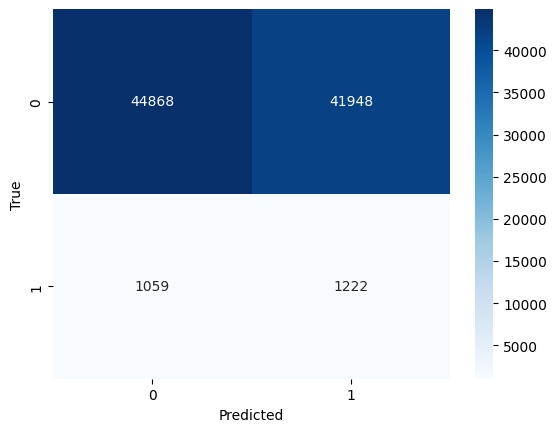

In [30]:
cm_LR = confusion_matrix(y_teste, pred_LR)
sns.heatmap(cm_LR, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### **Modelo de Random Forest**

**Tunning com o Random Search + Validação Cruzada**

In [22]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
param_dist = {
    'n_estimators': randint(50, 200),           # Número de árvores no ensemble
    'max_depth': randint(1, 20),                # Profundidade máxima das árvores
    'min_samples_split': randint(2, 20),        # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': randint(1, 20)          # Número mínimo de amostras em folhas
}

In [23]:
random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='f1', random_state=42, n_jobs=-1
)
random_search_rf.fit(X_treino, y_treino)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000203A564A710>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000203A560EB90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000203A811E850>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000203A817D990>},
                   random_state=42, scoring='f1')

In [24]:
print("Melhores Hiperparâmetros Encontrados:")
print(random_search_rf.best_params_)

Melhores Hiperparâmetros Encontrados:
{'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 94}


In [25]:
best_rf_model = random_search_rf.best_estimator_

In [26]:
pred_RF = best_rf_model.predict(X_teste)
Recall_RF = recall_score(y_teste, pred_RF)

In [32]:
print(f"O modelo apresentou um recall de {round(Recall_RF * 100, 2)}%")

O modelo apresentou um recall de 96.1%


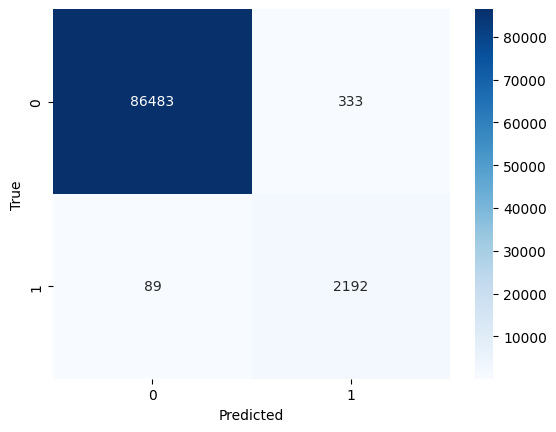

In [33]:
cm_RF = confusion_matrix(y_teste, pred_RF)
sns.heatmap(cm_RF, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Conclusão do Modelling**

* Como podemos ver na taxa de recall e na matriz de confusão o modelo de random forest teve um desempenho muito superior ao modelo de regressão logística, devido a isso iremos seguir com esse modelo. 

### **Salvando o modelo**

**Iremos começar criando uma função que irá replicar os tratamentos realizados no dataset, ele será utilizado nos dados antes de ser realizado uma predição.**

In [35]:
def tratamento(data):
    # Excluindo a coluna customer_id
    data.drop('customer_id', axis=1, inplace=True)

    # Formatando a coluna churn que antes era "active"
    data['churn'] = data['churn'].replace({0: 'Sim', 1: 'Não'})

    # Deixando a data no formato UNIX
    data['rental_date'] = data['rental_date'].apply(lambda x: x.timestamp())

    # Corrigindo formato da coluan churn para o modelo.
    data['churn'] = data['churn'].replace({"Não": 0, "Sim": 1}) 

In [36]:
joblib.dump(best_rf_model, "Modelo_churn_RF")

['Modelo_churn_RF']